# KEAP1 targeted prime editing sensor library

Generating pegRNAs to validate findings of Zucker et al. that VUS in KEAP1 are putative LOF variants. To do, we will be designing a prime editing sensor library looking at 10 known driver variants in KEAP1, and 40-50 VUS (including some germline variants). The plan is to design 5 pegRNAs/variant, with an emphasis on assaying multiple different protospacers. Will also be including ~4 hotspot variants in NRF2, and (1) silent substitutions for each assayed site, (2) non-targeting pegRNAs, (3) safe targeting pegRNAs.

**Also need to add in the NRF2 hotspot variants...**

Initial plan is to screen this library with an ARE reporter in H1299 and RPE1 PEmax cell lines.

In [151]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pegg import prime
from pegg import library
import re

In [152]:
#loading in dataset
keap1 = pd.read_excel('KEAP1_mutations_in_LUAD_MSK-IMPACT_with_germline.xlsx')
drivers = keap1[keap1['driver']==1.0].sort_values(by='n_patients_in_LUAD', ascending=False)
VUS = keap1[keap1['driver']==0.0].sort_values(by='n_patients_in_LUAD', ascending=False)
germline = keap1[keap1['n_patients_germline_LUAD']==1.0]

drivers['classification'] = 'driver'
VUS['classification']= 'VUS'
germline['classification'] = 'germline'

#select top 10 drivers, top 40 VUS, and the 10 germline variants
#2 of the VUS we can't generate a pegRNA for, so I'm expanding it to 42 VUS
keap1_selected = pd.concat((drivers[:10], VUS[0:42], germline)).reset_index().drop(columns = ['index', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])

#3 cases with multiple alternate alleles
#fixing these
r1 = []
r2 = []
for i, val in keap1_selected.iterrows():

    a = val['Alternate_Alleles']
    if ',' in a:
        b = a.split(',')
        r1.append(b[0])
        r2.append(b[1])
    else:
        r1.append(a)
        r2.append(None)

keap1_selected['Tumor_Seq_Allele2'] = r1
keap1_selected['Alternate_Allele_2'] = r2
keap1_selected['Variant_Type'] = 'SNP'

codons = []
for i, val in keap1_selected.iterrows():
    a = val['Alteration']
    codons.append(int(re.findall(r'\d+', a)[0]))

keap1_selected['codon'] = codons
keap1_selected

,Hugo_Symbol,Alteration,n_patients_in_LUAD,n_patients_germline_LUAD,driver,Chromosome,Start_Position,End_Position,Reference_Allele,Alternate_Alleles,classification,Tumor_Seq_Allele2,Alternate_Allele_2,Variant_Type,codon
0,KEAP1,p.R601L,10,NaN,1.0,19,10597401,10597401,C,A,driver,A,None,SNP,601
1,KEAP1,p.V155F,8,NaN,1.0,19,10610247,10610247,C,A,driver,A,None,SNP,155
2,KEAP1,p.G333C,7,NaN,1.0,19,10602581,10602581,C,A,driver,A,None,SNP,333
3,KEAP1,p.G186C,6,NaN,1.0,19,10610154,10610154,C,A,driver,A,None,SNP,186
4,KEAP1,p.G364C,6,NaN,1.0,19,10602488,10602488,C,A,driver,A,None,SNP,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,KEAP1,p.S508R,0,1.0,0.0,19,10600331,10600331,G,C,germline,C,None,SNP,508
58,KEAP1,p.G480R,0,1.0,0.0,19,10600417,10600417,C,G,germline,G,None,SNP,480
59,KEAP1,p.H210P,0,1.0,0.0,19,10610081,10610081,T,G,germline,G,None,SNP,210
60,KEAP1,p.M550K,0,1.0,0.0,19,10599927,10599927,A,T,germline,T,None,SNP,550


In [25]:
#load in the reference genome GRch37

filepath = '/Users/samgould/Desktop/FSR Lab/reference files/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'
chrom_dict, i = prime.genome_loader(filepath)

In [153]:
#generating pegRNAs

full_keap1 = prime.run(input_df = keap1_selected,
          input_format='cBioPortal',
          PAM = 'NGG',
          chrom_dict = chrom_dict,
          rankby='RF_Score',
          RTT_lengths = [5,10,15,25,30],
          PBS_lengths= [10,13,15],
          sensor_length=60,
          before_proto_context=5,
          pegRNAs_per_mut='All',
          min_RHA_size=1,
          RE_sites = ['CGTCTC', 'GAATTC'] #EcoRI and Esp3I
          )

#filter out RE sites and polyT
full_keap1 = full_keap1[full_keap1['contains_polyT_terminator']==False]
full_keap1 = full_keap1[full_keap1['contains_RE_site']==False]


# Function for selecting top pegRNAs at each protospacer

In [263]:
def peg_selector_diff_protospacers(df, num_pegs_per_variant, hgvsp_column_name='HGVSp'):
    """ 
    A function for selecting the top pegRNAs from those generated by PEGG,
    prioritizing the use of different protospacers (since this is the biggest determinant of editing activity).
    I.e., if there are 50 pegRNAs generated, and you select num_pegs_per_variant=5, it will select the top ranked pegRNA
    for each protospacer up to 5 pegRNAs (if there are fewer than 5 protospacers, it will just select more top ranked pegRNAs)

    """
    #selecting top 5 pegRNAs for each variant
    #prioritizing using different protospacers where possible

    uniq_vars = np.unique(df[hgvsp_column_name])


    selected_pegRNAs = []
    for val in uniq_vars:
        subset1 = df[df[hgvsp_column_name]==val]

        #select the top pegRNA for each protospacer
        uniq_protos = np.unique(subset1['Protospacer'])

        if len(uniq_protos)==1:
            #select the top 5 pegRNAs here in the case that there's only 1 protospacer
            s2 = subset1.sort_values(by='pegRNA_rank', ascending=True)
            selected_pegRNAs.append(s2[0:num_pegs_per_variant])


        else:
            if len(uniq_protos)>=num_pegs_per_variant:
                for i in uniq_protos:
                    p1 = subset1[subset1['Protospacer']==i]
                    top_peg = min(p1['pegRNA_rank'])
                    sub2 = p1[p1['pegRNA_rank']==top_peg]
                    selected_pegRNAs.append(sub2)
            elif len(uniq_protos)<num_pegs_per_variant:
                #if there aren't 5 unique protospacers
                #prioritize hitting all 3 protospacers
                #and then just get the top remaining pegRNAs to get to 5
                already_used = []
                for i in uniq_protos:
                    p1 = subset1[subset1['Protospacer']==i]
                    top_peg = min(p1['pegRNA_rank'])
                    already_used.append(top_peg)
                    sub2 = p1[p1['pegRNA_rank']==top_peg]
                    selected_pegRNAs.append(sub2)
                
                l = len(uniq_protos)
                s2 = subset1[~subset1['pegRNA_rank'].isin(already_used)]
                s2 = s2.sort_values(by='pegRNA_rank', ascending=True)
                selected_pegRNAs.append(s2[0:num_pegs_per_variant-l])
                

    diff_protos = pd.concat(selected_pegRNAs)

    #and then iterate through and select only the top 5 pegRNAs for each
    selected_pegRNAs2 = []
    for val in uniq_vars:
        s1 = diff_protos[diff_protos[hgvsp_column_name]==val]
        s1 = s1.sort_values(by='pegRNA_rank', ascending=True)

        selected_pegRNAs2.append(s1[0:num_pegs_per_variant])


    final_pegs = pd.concat(selected_pegRNAs2)
    final_pegs = final_pegs.sort_values(by=['mutation_idx', 'pegRNA_rank'])

    return final_pegs

In [264]:
#selecting pegRNAs for KEAP1
num_pegs_per_variant=5
df = full_keap1
hgvsp_column_name = 'Alteration'
keap1_final_pegs = peg_selector_diff_protospacers(df, num_pegs_per_variant, hgvsp_column_name)

In [267]:
np.unique(keap1_final_pegs['classification'], return_counts=True)

(array(['VUS', 'driver', 'germline'], dtype=object), array([200,  50,  43]))

In [268]:
u, c= np.unique(keap1_final_pegs['mutation_idx'], return_counts=True)
np.unique(c, return_counts=True) #all but one have at least 5 pegRNAs (1 has 3)

(array([3, 5]), array([ 1, 58]))

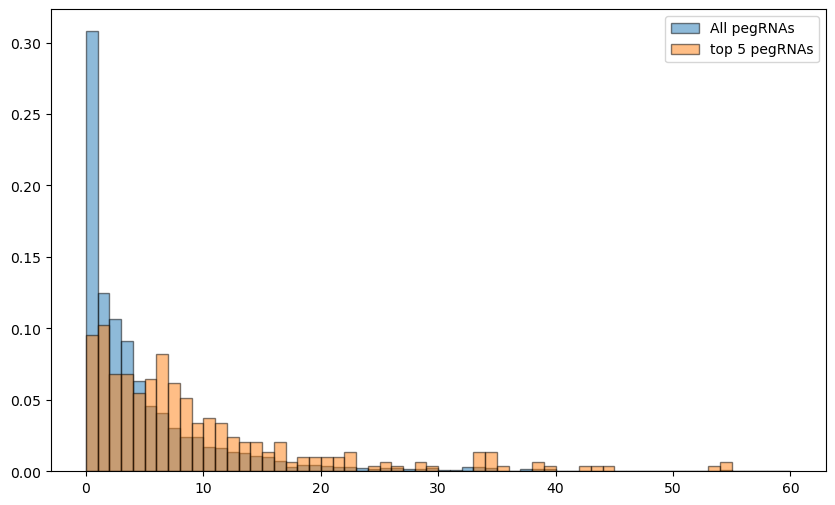

In [269]:
plt.figure(figsize=(10,6))
plt.hist(full_keap1['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black', density=True, alpha=.5, label='All pegRNAs')
plt.hist(keap1_final_pegs['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black', density=True, alpha=.5, label='top 5 pegRNAs')
plt.legend()


(array([18., 14., 15., 19., 29., 11.,  8.,  6.,  6.,  5., 14.,  4., 13.,
        14.,  3.,  8.,  8.,  7., 16.,  5.,  4., 14., 11.,  7.,  9.,  5.,
         9.,  4.,  7.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <BarContainer object of 30 artists>)

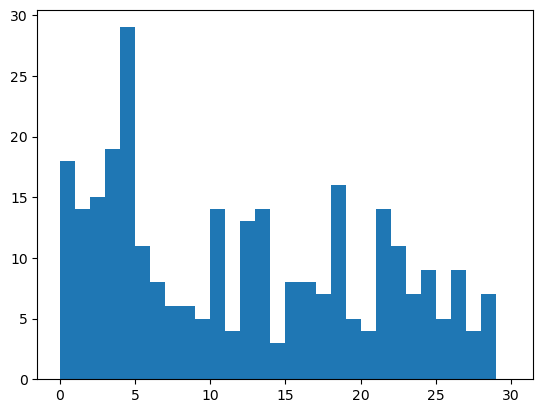

In [270]:
plt.hist(keap1_final_pegs['Distance_to_nick'], bins=np.linspace(0,30,31))

# Silent, non-targeting, safe-targeting, NRF2

In [326]:
#generate 50 non-targeting guides for prime editing
#start by generating a larger number (100) and then just filter
num_guides = 100
nontarget = library.nontargeting_guides(num_guides, edit_type='prime')
nontarget

#making them G+19 protospacers
l2 = list(nontarget['Protospacer'])
nontarget['Protospacer'] = ['G' + i[2:] for i in l2]

nontarget

,Protospacer,RTT,RTT_length,PBS,PBS_length,RTT_PBS,classification
0,GCGGAGGCTAAGCGTCGCAA,CGCATGCTTG,10,CGACGCTTAG,10,CGCATGCTTGCGACGCTTAG,non-targeting control
1,GGCTTCCGCGGCCCGTTCAA,CGCATGCTTG,10,AACGGGCCGC,10,CGCATGCTTGAACGGGCCGC,non-targeting control
2,GTCGTTTCCGCTTAACGGCG,CGCATGCCGC,10,CGTTAAGCGG,10,CGCATGCCGCCGTTAAGCGG,non-targeting control
3,GTAGGCGCGCCGCTCTCTAC,CGCATGCGTA,10,GAGAGCGGCG,10,CGCATGCGTAGAGAGCGGCG,non-targeting control
4,GCATATCGGGGCGAGACATG,CGCATGCCAT,10,GTCTCGCCCC,10,CGCATGCCATGTCTCGCCCC,non-targeting control
...,...,...,...,...,...,...,...
95,GACCCTCCGGATACGGACTG,CGCATGCCAG,10,TCCGTATCCG,10,CGCATGCCAGTCCGTATCCG,non-targeting control
96,GCGTTGGACTATGGCGGGTC,CGCATGCGAC,10,CCGCCATAGT,10,CGCATGCGACCCGCCATAGT,non-targeting control
97,GTACGGGGCGATCATCCACA,CGCATGCTGT,10,GGATGATCGC,10,CGCATGCTGTGGATGATCGC,non-targeting control
98,GAGAGTAGTAGACGCCCGGG,CGCATGCCCC,10,GGGCGTCTAC,10,CGCATGCCCCGGGCGTCTAC,non-targeting control


In [327]:
#adding sensor sequence and making sure there are no RE sites or polyT

#adding in random sensor sequence
#doesn't need to match up for non-targeting guides
rand_seqs = np.random.choice(['A','T','C','G'], size=(100,60))
rand_sensors_60 = ["".join(i) for i in rand_seqs]
nontarget['sensor_wt'] = rand_sensors_60

RE_sites_polyT = ['CGTCTC', 'GAATTC', 'GAGACG', 'TTTT']

filt = []
for i, val in nontarget.iterrows():
    p= val['Protospacer']
    pbs_rtt = val['RTT_PBS']
    s = val['sensor_wt']
    
    c = 0
    for k in RE_sites_polyT:
        if k in p:
            c+=1
        if k in s:
            c+=1
        if k in pbs_rtt:
            c+=1
        else:
            continue

    if c>0:
        filt.append(True)
    else:
        filt.append(False)

#and then generating 

nontarget['polyT_or_RE_site'] = filt
nontarget = nontarget[nontarget['polyT_or_RE_site']==False].reset_index()


74

In [103]:
#generate 100 safe-targeting loci that can be fed into PEGG
num_muts = 100
safe = library.safe_muts(num_muts, chrom_dict, organism='human')

safe_pegRNAs = prime.run(input_df = safe,
          input_format='cBioPortal',
          PAM = 'NGG',
          chrom_dict = chrom_dict,
          rankby='RF_Score',
          RTT_lengths = [10],
          PBS_lengths= [10],
          sensor_length=60,
          before_proto_context=5,
          pegRNAs_per_mut='All',
          min_RHA_size=1,
          RE_sites = ['CGTCTC', 'GAATTC'] #EcoRI and Esp3I
          )

safe_pegRNAs = safe_pegRNAs[0:50]

In [106]:
import gffutils

#load in genome annotation file
file = '/Users/samgould/Desktop/FSR Lab/reference files/gencode_v19.db'
db = gffutils.FeatureDB(file)

In [271]:
#silent substitutions
tx = 'ENST00000171111.5'
strand = '-'
chrom = 19
gene_name = 'KEAP1'

cds = list(db.children(tx, order_by='+end', featuretype=['CDS']))
start_end_cds = [[i.start, i.end] for i in cds]

neutral = library.neutral_substitutions(gene_name, chrom, strand, start_end_cds, chrom_dict)

#selecting the codons to target based on variants we're generating
uniq_codons = np.unique(keap1_final_pegs['codon'])

selected_neutrals = neutral[neutral['codon'].isin(uniq_codons)]

hg = []
for i, val in selected_neutrals.iterrows():
    a = val['ref_aa']
    b = val['codon']
    c = val['mut_aa']
    d = a + str(b) + c
    hg.append(d)

selected_neutrals['HGVSp'] = hg
selected_neutrals


,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,codon,ref_aa,mut_aa,classification,HGVSp
42,KEAP1,19,10610575,10610577,ONP,GGA,ACT,45,S,S,neutral,S45S
67,KEAP1,19,10610497,10610499,ONP,CCG,TCT,71,R,R,neutral,R71R
97,KEAP1,19,10610404,10610406,ONP,TGA,ACT,102,S,S,neutral,S102S
146,KEAP1,19,10610245,10610245,SNP,G,T,155,V,V,neutral,V155V
152,KEAP1,19,10610221,10610221,SNP,C,T,163,Q,Q,neutral,Q163Q
160,KEAP1,19,10610197,10610197,SNP,G,A,171,C,C,neutral,C171C
173,KEAP1,19,10610158,10610158,SNP,G,T,184,A,A,neutral,A184A
175,KEAP1,19,10610152,10610152,SNP,G,T,186,G,G,neutral,G186G
181,KEAP1,19,10610134,10610134,SNP,C,T,192,E,E,neutral,E192E
198,KEAP1,19,10610080,10610080,SNP,A,G,210,H,H,neutral,H210H


In [278]:
#and generating the pegRNAs

full_neutrals = prime.run(input_df = selected_neutrals,
          input_format='cBioPortal',
          PAM = 'NGG',
          chrom_dict = chrom_dict,
          rankby='RF_Score',
          RTT_lengths = [5,10,15,25,30],
          PBS_lengths= [10,13,15],
          sensor_length=60,
          before_proto_context=5,
          pegRNAs_per_mut='All',
          min_RHA_size=1,
          RE_sites = ['CGTCTC', 'GAATTC'] #EcoRI and Esp3I
          )

#filter out RE sites and polyT
full_neutrals = full_neutrals[full_neutrals['contains_polyT_terminator']==False]
full_neutrals = full_neutrals[full_neutrals['contains_RE_site']==False]


In [279]:
num_pegs_per_variant=2
df = full_neutrals
hgvsp_column_name = 'HGVSp'
final_neutrals = peg_selector_diff_protospacers(df, num_pegs_per_variant, hgvsp_column_name)

In [280]:
final_neutrals

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,codon,ref_aa,...,PEGG2_Score,RF_Score,pegRNA_rank,sensor_wt,sensor_alt,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site,pegRNA_id
0,0,KEAP1,19,10610575,10610577,ONP,GGA,ACT,45,S,...,21.315319,26.251592,1.0,ACGCCTCCACTGAGTGCAAGGCGGAGGTGACGCCCTCCCAGCATGG...,ACGCCTCCACTGAGTGCAAGGCGGAGGTGACGCCCAGTCAGCATGG...,reverse-complement,No Error,False,False,pegRNA_0
1,0,KEAP1,19,10610575,10610577,ONP,GGA,ACT,45,S,...,20.952681,22.378374,2.0,CGCCTCCACTGAGTGCAAGGCGGAGGTGACGCCCTCCCAGCATGGC...,CGCCTCCACTGAGTGCAAGGCGGAGGTGACGCCCAGTCAGCATGGC...,reverse-complement,No Error,False,False,pegRNA_1
81,1,KEAP1,19,10610497,10610499,ONP,CCG,TCT,71,R,...,19.504957,11.161459,1.0,TGCAGTGTGACGTCACACAGCTGCTGGCTGAGCCGCAGCTCGTTCA...,TGCAGTGTGACGTCACACAGCTGCTGGCTGAGTCTCAGCTCGTTCA...,reverse-complement,No Error,False,False,pegRNA_81
82,1,KEAP1,19,10610497,10610499,ONP,CCG,TCT,71,R,...,16.160514,8.878128,2.0,GCCTTTGGCATCATGAACGAGCTGCGGCTCAGCCAGCAGCTGTGTG...,GCCTTTGGCATCATGAACGAGCTGAGACTCAGCCAGCAGCTGTGTG...,reverse-complement,No Error,False,False,pegRNA_82
105,2,KEAP1,19,10610404,10610406,ONP,TGA,ACT,102,S,...,18.490583,9.501040,1.0,GGCCTTGAAGACAGGGCTGGATGAGGCCAGCACCACCTTGTGGGCC...,GGCCTTGAAGACAGGGCTGGAACTGGCCAGCACCACCTTGTGGGCC...,reverse-complement,No Error,False,False,pegRNA_105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,45,KEAP1,19,10597487,10597487,SNP,A,G,572,Y,...,16.914559,7.371350,16.0,CTTCCCGCAGGAGGCTATGATGGTCACACGTTCCTGGACAGTGTGG...,CTTCCCGCAGGAGGCTACGATGGTCACACGTTCCTGGACAGTGTGG...,reverse-complement,No Error,False,False,pegRNA_1899
1923,46,KEAP1,19,10597400,10597402,ONP,CCG,TCT,601,R,...,17.686369,31.120519,1.0,CATGGTGACAGCCACGCCCACCCCACTCCGGCCCGATGTCATTCGG...,CATGGTGACAGCCACGCCCACCCCACTTCTGCCCGATGTCATTCGG...,reverse-complement,No Error,False,False,pegRNA_1923
1924,46,KEAP1,19,10597400,10597402,ONP,CCG,TCT,601,R,...,19.410681,22.454640,2.0,GGCTCCATGGTGACAGCCACGCCCACCCCACTCCGGCCCGATGTCA...,GGCTCCATGGTGACAGCCACGCCCACCCCACTTCTGCCCGATGTCA...,reverse-complement,No Error,False,False,pegRNA_1924
1968,47,KEAP1,19,10597394,10597394,SNP,C,T,603,G,...,23.027625,38.216416,1.0,GCTTCCGGCAGGGCTCCATGGTGACAGCCACGCCCACCCCACTCCG...,GCTTCCGGCAGGGCTCCATGGTGACAGCCACGCCCACTCCACTCCG...,reverse-complement,No Error,False,False,pegRNA_1968


# Finally, adding the NRF2 variants

Picking 2 hotspots from each of the highly mutated KEAP1 interaction domains

In [175]:
impact = pd.read_csv('/Users/samgould/Desktop/FSR Lab/reference files/2020-06-16-MSK-IMPACT_EDITED.txt', sep='\t')
nrf2 = impact[impact['Hugo_Symbol'] =='NFE2L2']


In [203]:
nrf2 = nrf2[nrf2['Variant_Type']=='SNP']
nrf2_hg = list(nrf2['HGVSp'])
nrf2_hg = [i for i in nrf2_hg if type(i)==str]

u, c= np.unique(nrf2_hg, return_counts=True)
df = pd.DataFrame(dict(zip(['u', 'c'], [u,c]))).sort_values(by='c', ascending=False)
hgvsp = list(df[0:4]['u'])
hgvsp

['p.Glu79Gln', 'p.Arg34Gly', 'p.Glu82Asp', 'p.Gly31Glu']

In [227]:
hgvsc = ['ENST00000397062.3:c.100C>G', 'ENST00000397062.3:c.235G>C', 'ENST00000397062.3:c.246A>T','ENST00000397062.3:c.92G>A']

final4 = nrf2[nrf2['HGVSc'].isin(hgvsc)]
final4 = final4.drop_duplicates(subset='HGVSc')[['Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Variant_Type', 'HGVSp', 'HGVSc']].reset_index().drop(columns='index')
final4

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,Variant_Type,HGVSp,HGVSc
0,NFE2L2,2,178098810,178098810,C,G,SNP,p.Glu79Gln,ENST00000397062.3:c.235G>C
1,NFE2L2,2,178098945,178098945,G,C,SNP,p.Arg34Gly,ENST00000397062.3:c.100C>G
2,NFE2L2,2,178098953,178098953,C,T,SNP,p.Gly31Glu,ENST00000397062.3:c.92G>A
3,NFE2L2,2,178098799,178098799,T,A,SNP,p.Glu82Asp,ENST00000397062.3:c.246A>T


In [237]:
nrf2_pegs =  prime.run(input_df = final4,
          input_format='cBioPortal',
          PAM = 'NGG',
          chrom_dict = chrom_dict,
          rankby='RF_Score',
          RTT_lengths = [5,10,15,25,30],
          PBS_lengths= [10,13,15],
          sensor_length=60,
          before_proto_context=5,
          pegRNAs_per_mut='All',
          min_RHA_size=1,
          RE_sites = ['CGTCTC', 'GAATTC'] #EcoRI and Esp3I
          )

nrf2_pegs = nrf2_pegs[nrf2_pegs['contains_polyT_terminator']==False]
nrf2_pegs = nrf2_pegs[nrf2_pegs['contains_RE_site']==False]


In [284]:
num_pegs_per_variant=5
df = nrf2_pegs
hgvsp_column_name = 'HGVSp'
final_nrf2 = peg_selector_diff_protospacers(df, num_pegs_per_variant, hgvsp_column_name)

In [286]:
final_nrf2

,mutation_idx,Hugo_Symbol,Chromosome,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,Variant_Type,HGVSp,HGVSc,...,PEGG2_Score,RF_Score,pegRNA_rank,sensor_wt,sensor_alt,sensor_orientation,sensor_error,contains_polyT_terminator,contains_RE_site,pegRNA_id
0,0,NFE2L2,2,178098810,178098810,C,G,SNP,p.Glu79Gln,ENST00000397062.3:c.235G>C,...,13.730379,5.151958,1.0,TTACAACTAGATGAAGAGACAGGTGAATTTCTCCCAATTCAGCCAG...,TTACAACTAGATGAACAGACAGGTGAATTTCTCCCAATTCAGCCAG...,reverse-complement,No Error,False,False,pegRNA_0
1,0,NFE2L2,2,178098810,178098810,C,G,SNP,p.Glu79Gln,ENST00000397062.3:c.235G>C,...,13.582246,5.147473,2.0,TTACAACTAGATGAAGAGACAGGTGAATTTCTCCCAATTCAGCCAG...,TTACAACTAGATGAACAGACAGGTGAATTTCTCCCAATTCAGCCAG...,reverse-complement,No Error,False,False,pegRNA_1
2,0,NFE2L2,2,178098810,178098810,C,G,SNP,p.Glu79Gln,ENST00000397062.3:c.235G>C,...,13.595865,3.104152,3.0,TTACAACTAGATGAAGAGACAGGTGAATTTCTCCCAATTCAGCCAG...,TTACAACTAGATGAACAGACAGGTGAATTTCTCCCAATTCAGCCAG...,reverse-complement,No Error,False,False,pegRNA_2
3,0,NFE2L2,2,178098810,178098810,C,G,SNP,p.Glu79Gln,ENST00000397062.3:c.235G>C,...,13.345996,3.091513,4.0,TTACAACTAGATGAAGAGACAGGTGAATTTCTCCCAATTCAGCCAG...,TTACAACTAGATGAACAGACAGGTGAATTTCTCCCAATTCAGCCAG...,reverse-complement,No Error,False,False,pegRNA_3
6,0,NFE2L2,2,178098810,178098810,C,G,SNP,p.Glu79Gln,ENST00000397062.3:c.235G>C,...,12.138233,0.269007,7.0,TACAACTAGATGAAGAGACAGGTGAATTTCTCCCAATTCAGCCAGC...,TACAACTAGATGAACAGACAGGTGAATTTCTCCCAATTCAGCCAGC...,reverse-complement,No Error,False,False,pegRNA_6
12,1,NFE2L2,2,178098945,178098945,G,C,SNP,p.Arg34Gly,ENST00000397062.3:c.100C>G,...,13.193410,1.065407,1.0,GCTGACTGAAGTCAAATACTTCTCGACTTACTCCAAGATCTATATC...,GCTGACTGAAGTCAAATACTTCTCCACTTACTCCAAGATCTATATC...,reverse-complement,No Error,False,False,pegRNA_12
13,1,NFE2L2,2,178098945,178098945,G,C,SNP,p.Arg34Gly,ENST00000397062.3:c.100C>G,...,10.907401,0.770724,2.0,GCTGACTGAAGTCAAATACTTCTCGACTTACTCCAAGATCTATATC...,GCTGACTGAAGTCAAATACTTCTCCACTTACTCCAAGATCTATATC...,reverse-complement,No Error,False,False,pegRNA_13
14,1,NFE2L2,2,178098945,178098945,G,C,SNP,p.Arg34Gly,ENST00000397062.3:c.100C>G,...,12.846632,0.669012,3.0,GCTGACTGAAGTCAAATACTTCTCGACTTACTCCAAGATCTATATC...,GCTGACTGAAGTCAAATACTTCTCCACTTACTCCAAGATCTATATC...,reverse-complement,No Error,False,False,pegRNA_14
15,1,NFE2L2,2,178098945,178098945,G,C,SNP,p.Arg34Gly,ENST00000397062.3:c.100C>G,...,12.656444,0.536606,4.0,GCTGACTGAAGTCAAATACTTCTCGACTTACTCCAAGATCTATATC...,GCTGACTGAAGTCAAATACTTCTCCACTTACTCCAAGATCTATATC...,reverse-complement,No Error,False,False,pegRNA_15
16,1,NFE2L2,2,178098945,178098945,G,C,SNP,p.Arg34Gly,ENST00000397062.3:c.100C>G,...,13.003221,0.474190,5.0,GCTGACTGAAGTCAAATACTTCTCGACTTACTCCAAGATCTATATC...,GCTGACTGAAGTCAAATACTTCTCCACTTACTCCAAGATCTATATC...,reverse-complement,No Error,False,False,pegRNA_16


# Combining and generating oligos

- F+E scaffold
- G+19 protospacer
- 60 nt sensor
- Check no oligos above 300 nt
- Add in 5 nt sensor barcode
    - We actually don't have enough room to add a barcode
    - BUT, the sensor sequences should be unique enough that this shouldn't be an issue (they can act as their own barcodes)
- Added random sensor sequence to the non-targeting guides

In [328]:
len(keap1_final_pegs) + len(final_nrf2) + len(final_neutrals) + len(safe_pegRNAs) + len(nontarget[0:41])

500

In [333]:
keap1_final_pegs['peg_type'] = 'keap1_targeting'
keap1_final_pegs = keap1_final_pegs.rename(columns={'Alteration':'HGVSp'})
final_nrf2['peg_type'] = 'nrf2_targeting'
final_neutrals['peg_type'] = 'keap1_silent'
safe_pegRNAs['peg_type'] = 'safe_targeting'
nontarget['peg_type'] = 'non_targeting'

combined = pd.concat((keap1_final_pegs, final_nrf2, final_neutrals, safe_pegRNAs, nontarget[0:41]))

In [345]:
gRNA_F_E = 'GTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC'
#F+E scaffold

combined_oligos = prime.prime_oligo_generator(combined, epeg=True, epeg_motif='tevopreQ1', five_prime_adapter='AGCGTACACGTCTCACACC', three_prime_adapter='GAATTCTAGATCCGGTCGTCAAC', gRNA_scaff=gRNA_F_E)

In [341]:
np.unique([len(i) for i in combined_oligos['pegRNA_oligo']], return_counts=True)

(array([267, 270, 272, 275, 277, 280, 282, 287, 290, 292, 295, 297]),
 array([ 11,   8, 124,  11,  42,  21,  29,  46,  20, 102,  32,  54]))

In [348]:
combined_oligos['pegRNA_id'] = [f'pegRNA_{i}' for i in range(1,501)]

In [358]:
#combined_oligos.to_csv('KEAP1_NRF2_library.csv', index=False)


In [359]:
oligos_only = combined_oligos[['pegRNA_id', 'pegRNA_oligo']]
#oligos_only.to_csv('oligos_only.csv', index=False)

# Summary and visualizations

In [361]:
#saving input files
#keap1_selected.to_csv('input_variants/KEAP1_input_variants.csv', index=False)
#final4.to_csv('input_variants/NRF2_input_variants.csv', index=False)
#selected_neutrals.to_csv('input_variants/KEAP1_silent_input_variants.csv', index=False)

In [379]:
d = keap1_selected[keap1_selected['classification']=='driver']
v = keap1_selected[keap1_selected['classification']=='VUS']

In [408]:
jj = combined_oligos[combined_oligos['peg_type']=='keap1_targeting'].drop_duplicates(subset='HGVSp')


d = jj[jj['classification']=='driver']
v = jj[jj['classification']=='VUS']
g = jj[jj['classification']=='germline']
g


,mutation_idx,Hugo_Symbol,HGVSp,n_patients_in_LUAD,n_patients_germline_LUAD,driver,Chromosome,Start_Position,End_Position,Reference_Allele,...,contains_polyT_terminator,contains_RE_site,pegRNA_id,peg_type,HGVSc,ref_aa,mut_aa,index,polyT_or_RE_site,pegRNA_oligo
2373,52.0,KEAP1,p.R260L,3.0,1.0,1.0,19,10602799.0,10602799.0,C,...,False,False,pegRNA_251,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGCTTCCACGCCTGCATCAACGTTTAAG...
2400,53.0,KEAP1,p.A184G,1.0,1.0,NaN,19,10610159.0,10610159.0,G,...,False,False,pegRNA_256,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGCGAAGTTGGCGATGCCGAGTTTAAG...
2424,54.0,KEAP1,p.R415H,1.0,1.0,1.0,19,10602334.0,10602334.0,C,...,False,False,pegRNA_261,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGATGACCCCCACCCCGATGGTTTAAG...
2451,55.0,KEAP1,p.R536C,0.0,1.0,0.0,19,10599970.0,10599970.0,G,...,False,False,pegRNA_266,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGCTGGGGGCTATGATGGTCGTTTAAG...
2454,57.0,KEAP1,p.S508R,0.0,1.0,0.0,19,10600331.0,10600331.0,G,...,False,False,pegRNA_269,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGAATGAACACCATCCGAAGCGTTTAAG...
2511,58.0,KEAP1,p.G480R,0.0,1.0,0.0,19,10600417.0,10600417.0,C,...,False,False,pegRNA_274,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGACACTCAGCTGAATTAAGGGTTTAAG...
2574,59.0,KEAP1,p.H210P,0.0,1.0,0.0,19,10610081.0,10610081.0,T,...,False,False,pegRNA_279,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGAGTTGCACCAGCGTGCCCGTTTAAG...
2604,60.0,KEAP1,p.M550K,0.0,1.0,0.0,19,10599927.0,10599927.0,A,...,False,False,pegRNA_284,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGCTGGTGGACAGTGATCCCCGTTTAAG...
2660,61.0,KEAP1,p.V465L,0.0,1.0,0.0,19,10600462.0,10600462.0,C,...,False,False,pegRNA_289,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGGCCCCAATGCTGACACGAGTTTAAG...


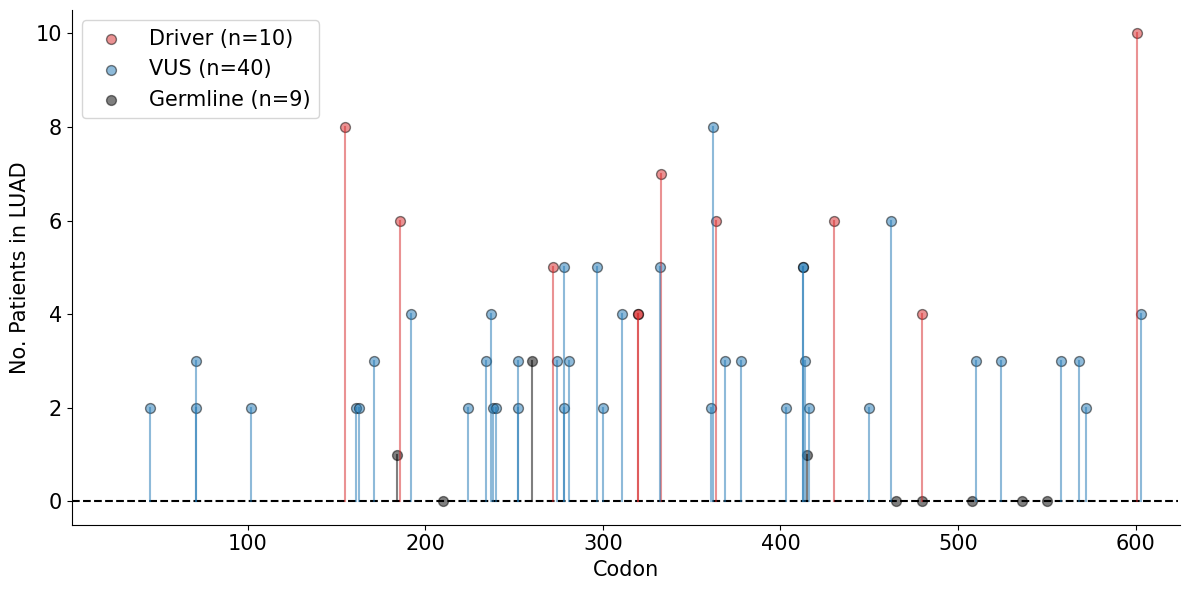

In [409]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot([1,624], [0,0], linestyle='dashed', color='black')
ax.set_xlim(1,625)


for i, val in d.iterrows():
    ax.plot([val['codon'], val['codon']], [0, val['n_patients_in_LUAD']], color='tab:red',alpha=.5)
    
for i, val in v.iterrows():
    ax.plot([val['codon'], val['codon']], [0, val['n_patients_in_LUAD']], color='tab:blue',alpha=.5)  

for i, val in g.iterrows():
    ax.plot([val['codon'], val['codon']], [0, val['n_patients_in_LUAD']], color='black',alpha=.5)  

ax.scatter(d['codon'], d['n_patients_in_LUAD'], color='tab:red', label='Driver (n=10)',edgecolor='black', s=50,alpha=.5)
ax.scatter(v['codon'], v['n_patients_in_LUAD'], color='tab:blue', label='VUS (n=40)', edgecolor='black', s=50,alpha=.5)
ax.scatter(g['codon'], g['n_patients_in_LUAD'], color='black', label='Germline (n=9)', edgecolor='black', s=50,alpha=.5)


ax.set_ylabel('No. Patients in LUAD', fontsize=15)
ax.set_xlabel('Codon', fontsize=15)
#plt.scatter()
ax.legend(fontsize=15)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()

In [407]:
np.unique(jj['classification'], return_counts=True)

(array(['VUS', 'driver', 'germline'], dtype=object), array([40, 10,  9]))

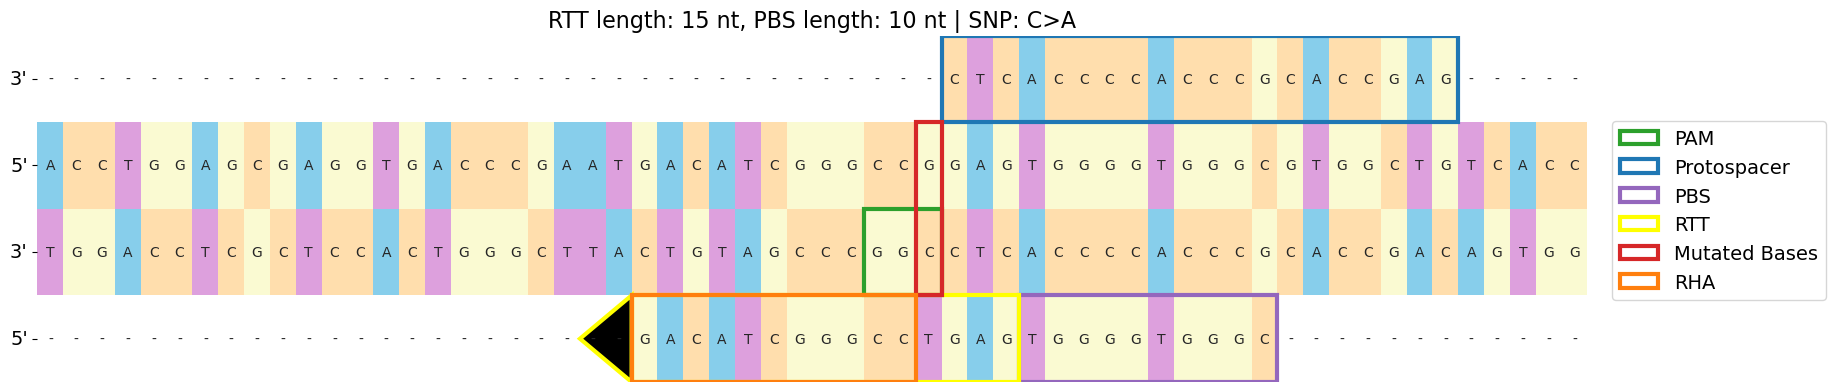

In [423]:
prime.sensor_viz(combined_oligos, 3)

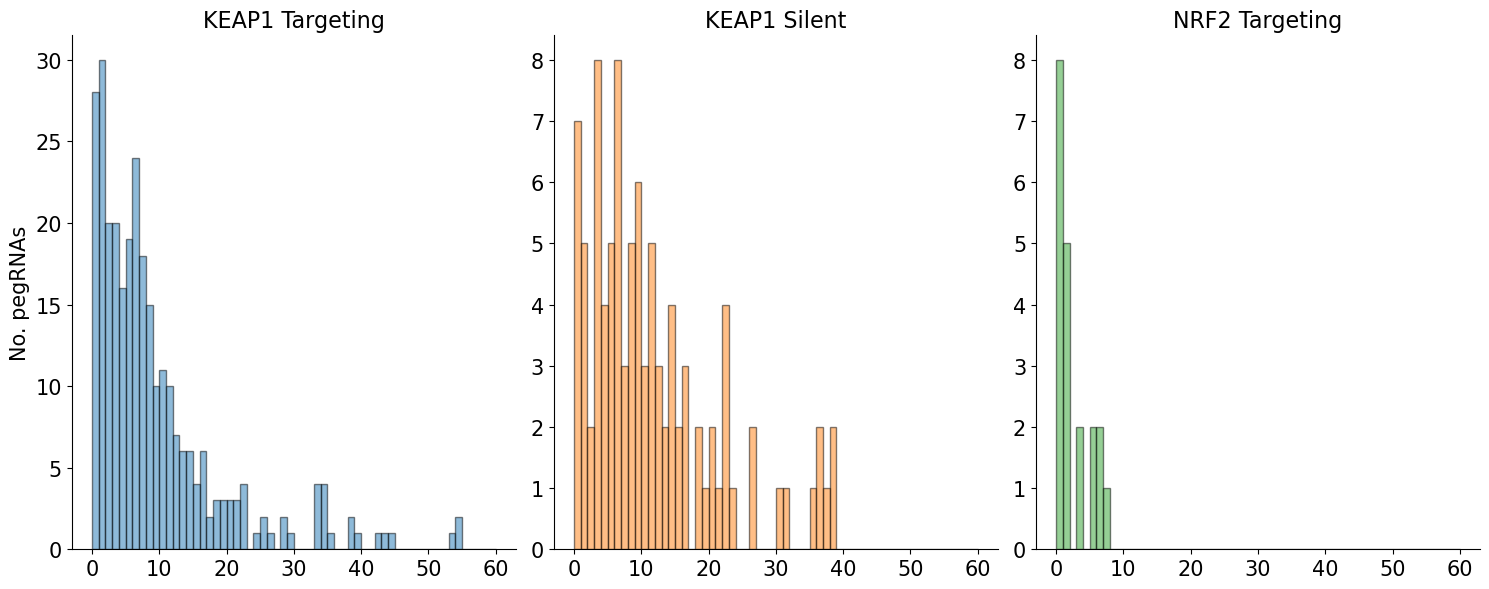

In [443]:
kt = combined_oligos[combined_oligos['peg_type']=='keap1_targeting']
ks = combined_oligos[combined_oligos['peg_type']=='keap1_silent']
n = combined_oligos[combined_oligos['peg_type']=='nrf2_targeting']

fig, ax = plt.subplots(1,3, figsize=(15,6), sharex=True)
ax[0].hist(kt['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black', alpha=.5, label='KEAP1-targeting')
ax[1].hist(ks['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black',  alpha=.5, label='KEAP1-silent', color='tab:orange')
ax[2].hist(n['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black', alpha=.5, label='NRF2-targeting', color='tab:green')

ax[0].spines[['top', 'right']].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel('No. pegRNAs', fontsize=15)

ax[0].set_title('KEAP1 Targeting', fontsize=16)
ax[1].set_title('KEAP1 Silent', fontsize=16)
ax[2].set_title('NRF2 Targeting', fontsize=16)

fig.tight_layout()

In [413]:
plt.figure(figsize=(10,6))
plt.hist(full_keap1['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black', density=True, alpha=.5, label='All pegRNAs')
plt.hist(keap1_final_pegs['RF_Score'], bins=np.linspace(0,60,61), linewidth=1, edgecolor='black', density=True, alpha=.5, label='top 5 pegRNAs')
plt.legend()

'GGCTCCATGGTGACAGCCACGCCCACCCCACTCCGGCCCGATGTCATTCGGGTCACCTCG'

In [422]:
combined_oligos.iloc[3]['PAM_strand']


'+'

In [426]:
np.unique(combined_oligos['peg_type'], return_counts=True)

(array(['keap1_silent', 'keap1_targeting', 'non_targeting',
        'nrf2_targeting', 'safe_targeting'], dtype=object),
 array([ 96, 293,  41,  20,  50]))

In [427]:
combined_oligos

,mutation_idx,Hugo_Symbol,HGVSp,n_patients_in_LUAD,n_patients_germline_LUAD,driver,Chromosome,Start_Position,End_Position,Reference_Allele,...,contains_polyT_terminator,contains_RE_site,pegRNA_id,peg_type,HGVSc,ref_aa,mut_aa,index,polyT_or_RE_site,pegRNA_oligo
0,0.0,KEAP1,p.R601L,10.0,NaN,1.0,19,10597401.0,10597401.0,C,...,False,False,pegRNA_1,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGACCCGAATGACATCGGGCGTTTAAG...
1,0.0,KEAP1,p.R601L,10.0,NaN,1.0,19,10597401.0,10597401.0,C,...,False,False,pegRNA_2,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGAGGTGACCCGAATGACATGTTTAAG...
12,0.0,KEAP1,p.R601L,10.0,NaN,1.0,19,10597401.0,10597401.0,C,...,False,False,pegRNA_3,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGAGGTGACCCGAATGACATCGTTTAAG...
17,0.0,KEAP1,p.R601L,10.0,NaN,1.0,19,10597401.0,10597401.0,C,...,False,False,pegRNA_4,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGAGCCACGCCCACCCCACTCGTTTAAG...
44,0.0,KEAP1,p.R601L,10.0,NaN,1.0,19,10597401.0,10597401.0,C,...,False,False,pegRNA_5,keap1_targeting,NaN,NaN,NaN,NaN,NaN,AGCGTACACGTCTCACACCGGATACAGACACCTGGAGCGGTTTAAG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,pegRNA_496,non_targeting,NaN,NaN,NaN,45.0,False,AGCGTACACGTCTCACACCGGCCGTTCCGAGATACTTGAGTTTAAG...
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,pegRNA_497,non_targeting,NaN,NaN,NaN,47.0,False,AGCGTACACGTCTCACACCGCGGCATACGGGACACACGCGTTTAAG...
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,pegRNA_498,non_targeting,NaN,NaN,NaN,48.0,False,AGCGTACACGTCTCACACCGGCTCCATCGCCGCGATAATGTTTAAG...
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,pegRNA_499,non_targeting,NaN,NaN,NaN,50.0,False,AGCGTACACGTCTCACACCGCGATCGAGGTTGCATTCGGGTTTAAG...


In [450]:
len(np.unique(combined_oligos['pegRNA_oligo']))

500

In [451]:
len(np.unique(combined_oligos['RTT_PBS']))

500

In [453]:
oligos_only_twist = oligos_only.rename(columns = {'pegRNA_id':'name', 'pegRNA_oligo':'sequence'})
oligos_only_twist.to_csv('KEAP1_oligos_only_twist.csv', index=False)

In [464]:
tt = combined_oligos[combined_oligos['peg_type'].isin(['keap1_targeting'])]

l2 = []
for i in np.unique(tt['mutation_idx']):

    jjj =tt[tt['mutation_idx']==i]
    l2.append(len(np.unique(jjj['Protospacer'])))
    
np.unique(l2, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 6,  6, 11, 12, 24]))

In [467]:
final_neutrals

0       reverse-complement
1       reverse-complement
81      reverse-complement
82      reverse-complement
105     reverse-complement
               ...        
1899    reverse-complement
1923    reverse-complement
1924    reverse-complement
1968    reverse-complement
1983    reverse-complement
Name: sensor_orientation, Length: 96, dtype: object